In [54]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(X_train,y_train),(X_test,y_test) = mnist.load_data()
X_train ,X_test = X_train / 255.0,X_test / 255.0

X_train = X_train.reshape((60000,784))
X_test = X_test.reshape((10000,784))
X_train.shape,X_test.shape

((60000, 784), (10000, 784))

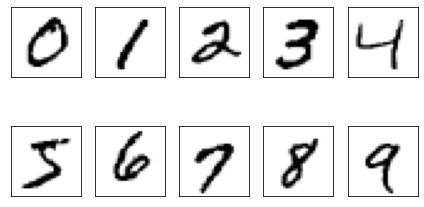

In [8]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows = 2,ncols = 5,sharex = True,sharey = True)
ax = ax.flatten()
for i in range(10):
  img = X_train[y_train == i][0].reshape(28,28)
  ax[i].imshow(img,cmap = "Greys")
ax[0].set_xticks([])
ax[1].set_yticks([])
plt.tight_layout()
plt.show()

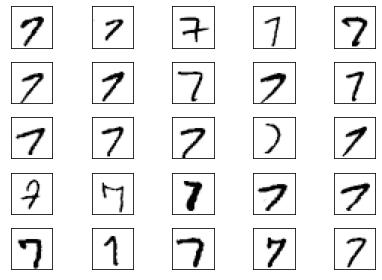

In [9]:
fig,ax = plt.subplots(nrows = 5,ncols = 5,sharex = True,sharey = True)
ax = ax.flatten()
for i in range(25):
  img = X_train[y_train == 7][i].reshape(28,28)
  ax[i].imshow(img,cmap = "Greys")
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [67]:
import numpy as np
import sys 
class NeuralNetMLP(object):
  def __init__(self,n_hidden = 30,l2 = 0.0,epochs = 100,eta =  0.001,shuffle = True,minibatch_size = 1,seed = None):
    self.random = np.random.RandomState(seed)
    self.n_hidden = n_hidden
    self.l2 = l2
    self.epochs = epochs
    self.eta = eta
    self.shuffle = shuffle
    self.minibatch_size = minibatch_size
  def _onehot(self,y,n_classes):
    onehot = np.zeros((n_classes,y.shape[0]))
    for idx,val in enumerate(y.astype(int)):
      onehot[val,idx] = 1
    return onehot.T
  def _sigmoid(self,z):
    return 1 / (1+np.exp(-np.clip(z,-250,250)))
  def _forward(self,X):
    z_h = np.dot(X,self.w_h) + self.b_h
    a_h = self._sigmoid(z_h)
    z_out = np.dot(a_h,self.w_out) + self.b_out
    a_out = self._sigmoid(z_out)
    return z_h,a_h,z_out,a_out
  def _compute_cost(self,y_enc,output):
    L2_term = (self.l2 * (np.sum(self.w_h **2) + np.sum(self.w_out **2 )))
    term1 = -y_enc *(np.log(output))
    term2 = (1-y_enc) * np.log(1 - output)
    cost =  np.sum(term1 - term2) + L2_term
    return cost
  def predict(self,X):
    z_h,a_h,z_out,a_out = self._forward(X)
    y_pred = np.argmax(z_out,axis = 1)
    return y_pred
  def fit(self,X_train,y_train,X_valid,y_valid):
    n_output = np.unique(y_train).shape[0]
    n_features = X_train.shape[1]
    self.b_h = np.zeros(self.n_hidden)
    self.w_h = self.random.normal(loc = 0.0,scale = 0.1,size=(n_features,self.n_hidden))
    self.b_out = np.zeros(n_output)
    self.w_out = self.random.normal(loc= 0.0,scale = 0.1,size = (self.n_hidden,n_output))
    epoch_strlen = len(str(self.epochs))
    self.eval_ = {"cost" : [],"train_acc" : [],"valid_acc" : []}
    y_train_enc = self._onehot(y_train,n_output)
    for i in range(self.epochs):
      indices = np.arange(X_train.shape[0])
      if self.shuffle:
        self.random.shuffle(indices)
      for start_idx in range(0,indices.shape[0]- self.minibatch_size + 1,self.minibatch_size):
        batch_idx = indices[start_idx:start_idx+self.minibatch_size]
        z_h,a_h,z_out,a_out = self._forward(X_train[batch_idx])
        sigma_out = a_out - y_train_enc[batch_idx]
        sigmoid_derivative_h = a_h * (1 - a_h)
        sigma_h = (np.dot(sigma_out,self.w_out.T) * sigmoid_derivative_h) 
        grad_w_h = np.dot(X_train[batch_idx].T,sigma_h)
        grad_b_h = np.sum(sigma_h,axis = 0)
        grad_w_out = np.dot(a_h.T,sigma_out)
        grad_b_out = np.sum(sigma_out,axis = 0)
        delta_w_h = (grad_w_h + self.l2 * self.w_h)
        delta_b_h = (grad_b_h)
        self.w_h -= self.eta * delta_w_h
        self.b_h -= self.eta * delta_b_h
        delta_w_out = (grad_w_out + self.l2 * self.w_out)
        delta_b_out = grad_b_out

        self.w_out -= self.eta * delta_w_out
        self.b_out -= self.eta * delta_b_out
      z_h,a_h,z_out,a_out = self._forward(X_train)
      cost = self._compute_cost(y_enc = y_train_enc,output = a_out)
      y_train_pred = self.predict(X_train)
      y_valid_pred = self.predict(X_valid)
      train_acc = ((np.sum(y_train ==y_train_pred)).astype(np.float) / X_train.shape[0])
      valid_acc = ((np.sum(y_valid ==y_valid_pred)).astype(np.float) / X_valid.shape[0])
      sys.stderr.write("\r%0*d/%d | 비용: %.2f | 훈련/검증 정확도: %.2f%%/%2.f%%" % (epoch_strlen,i+1,self.epochs,cost,train_acc*100,valid_acc*100))
      sys.stderr.flush()
      self.eval_['cost'].append(cost)
      self.eval_['train_acc'].append(train_acc)
      self.eval_['valid_acc'].append(valid_acc)
    return self
  



In [68]:
nn = NeuralNetMLP(n_hidden = 100,l2 = 0.01,epochs=200,eta = 0.0005,minibatch_size=100,shuffle=True,seed = 1)

In [69]:
nn.fit(X_train = X_train[:55000],y_train = y_train[:55000],X_valid = X_train[55000:],y_valid=y_test[55000:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
200/200 | 비용: 8004.06 | 훈련/검증 정확도: 98.45%/ 0%